In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
import nibabel as nb
from os import sep
from copy import deepcopy
from scipy.interpolate import interp1d
from matplotlib import colors
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
import trimesh
import open3d as o3d
from tools import compute_rel_power, get_crossover, detect_crossing_points, data_to_rgb
from sklearn.preprocessing import minmax_scale
from joblib import Parallel, delayed

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [109]:
def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow


def plot_vertex_results(vx, layer_power, info, freqs, smooth_power, crossover, ab_pow, g_pow):
    f, ax = plt.subplots(1,3, figsize=(12,3))
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=info["layers"]))[:,:3]
    for ix in range(info["layers"]):
        ax[0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=0.5)
    ax[0].set_title("PSD per layer - offset")
    ax[0].axvline(7, lw=0.5, c="black")
    ax[0].axvline(30, lw=0.5, c="black")
    ax[0].axvline(50, lw=0.5, c="black")
    ax[1].set_title("Relative PSD per layer")
    layer_deets = plot_csd(
        smooth_power, [vx],
        info["big_brain_layers_path"], 
        freqs, ax=ax[1], cmap="YlGnBu",
        vmin_vmax="norm", cb=False, return_details=True
    )
    yl=ax[1].get_ylim()
    ax[1].plot([7,7], yl,':', lw=1.5, c="white")
    ax[1].plot([30,30], yl,':', lw=1.5, c="white")
    ax[1].plot([50,50], yl,':', lw=1.5, c="white")
    ax[1].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1)


    ax[2].set_title("Crossover")
    ax[2].plot(
        ab_pow, np.linspace(0, 1, smooth_power.shape[0]), label='alpha-beta', c="green"
    )
    ax[2].plot(
        g_pow, np.linspace(0, 1, smooth_power.shape[0]), label='gamma', c="blue"
    )

    ax[2].set_ylim(1, 0)
    ax[2].set_xlim(0, 1)
    ax[2].set_yticks(np.linspace(0,1, num=11))
    ax[2].set_yticklabels(np.arange(1,12));
    for th, lab in layer_deets[0]:
        ax[2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[2].annotate(lab,[0.01, th-0.01],size=15)
    ax[2].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")
    handles = [
        Line2D([], [], color="blue", label="Gamma"),
        Line2D([], [], color="green", label="Alpha-beta"),
        Line2D([], [], color="red", linestyle="dashed", label="Crossover")
    ]
    ax[2].legend(handles=handles, loc=8, frameon=True, fontsize="xx-small")
    ax[2].set_xlabel("Relative Power")
    return ax


def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

In [2]:
dir_search = new_files.Files()
dataset_path = "/home/common/bonaiuto/multiburst/derivatives/processed/"

all_psd_wholebrain = dir_search.get_files(
    dataset_path,
    "*.npy", prefix="PSD_"
)
all_psd_wholebrain.sort()
dict_epoch = {i: [j for j in all_psd_wholebrain if i in j] for i in ["motor", "visual"]}
all_info = dir_search.get_files(
    dataset_path,
    "*.json", prefix="info"
)

In [3]:
data_file = dict_epoch["motor"][0]
data = np.load(data_file)
core_path = sep.join(data_file.split(sep)[:-1]) + sep
core_name = data_file.split(sep)[-1].split("_")[-1].split(".")[0]
subject = "-".join(core_name.split("-")[1:3])
info_file = [i for i in all_info if subject in i][0]
with open(info_file) as pipeline_file:
    info = json.load(pipeline_file)

data = np.array(np.split(data, 11, axis=0)) # layer x vertex x freqs
flims = [0.1,125]
freqs = np.linspace(*flims, data.shape[2])
vx_no = data.shape[1]

In [4]:
power_metric = np.sum(np.mean(data, axis=0), axis=-1)

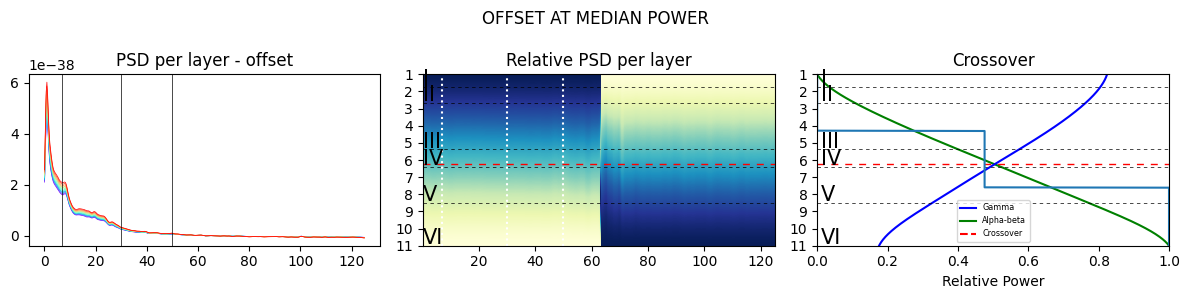

In [86]:
vx = 4000
layer_power = data[:, vx, :]
layer_power = layer_power - np.median(layer_power, axis=1).reshape(-1, 1)
relative_power = compute_rel_power(layer_power, freqs)
smooth_power = csd_smooth(relative_power)
depth_s, freq_s = smooth_power.shape

try:
    crossover = get_crossover(freqs, smooth_power, smooth_power)
except:
    crossover = 0

ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

ab_pow = np.mean(smooth_power[:, ab_idx], axis=1)
g_pow = np.mean(smooth_power[:, g_idx], axis=1)

plot = plot_vertex_results(
    vx, layer_power, info, freqs, 
    smooth_power, crossover, ab_pow, g_pow
)

y = np.linspace(0, 1, num=depth_s)
x = minmax_scale(ab_pow - g_pow)
ranges = [y < 0.33, (y >= 0.33) & (y < 0.66), y >= 0.66]
for r in ranges:
    x[r] = np.mean(x[r])
x = minmax_scale(x)
plot[2].plot(x, y)

plt.suptitle("OFFSET AT MEDIAN POWER")
plt.tight_layout()

print(np.mean(x[ranges[0]]) - np.mean(x[ranges[2]]))


1.0000000000000002


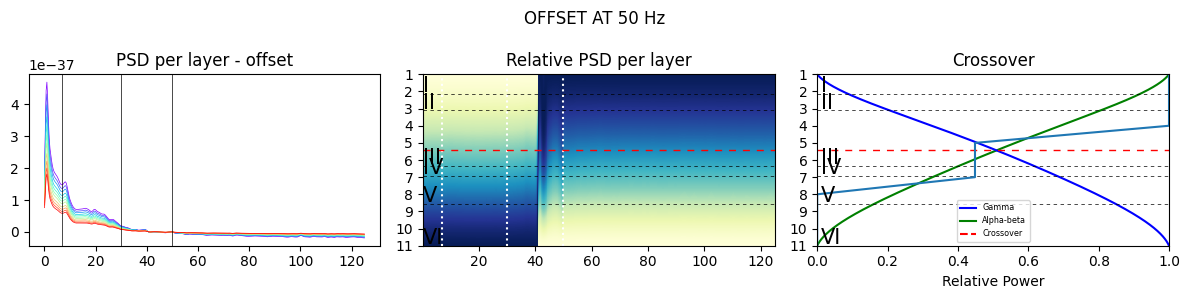

In [110]:
vx = 1000
layer_power = data[:, vx, :]
layer_power = layer_power - layer_power[:,np.where(freqs >= 50)[0][0]].reshape(-1, 1)
relative_power = compute_rel_power(layer_power, freqs)
smooth_power = csd_smooth(relative_power)
depth_s, freq_s = smooth_power.shape

try:
    crossover = get_crossover(freqs, smooth_power, smooth_power)
except:
    crossover = 0

ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

ab_pow = np.mean(smooth_power[:, ab_idx], axis=1)
g_pow = np.mean(smooth_power[:, g_idx], axis=1)

plot = plot_vertex_results(
    vx, layer_power, info, freqs, 
    smooth_power, crossover, ab_pow, g_pow
)

ab_pow_r = np.mean(relative_power[:, ab_idx], axis=1)
g_pow_r = np.mean(relative_power[:, g_idx], axis=1)
y = np.linspace(0, 1, num=relative_power.shape[0])
x = minmax_scale(ab_pow_r - g_pow_r)
ranges = [y < 0.33, (y >= 0.33) & (y < 0.66), y >= 0.66]
for r in ranges:
    x[r] = np.mean(x[r])
x = minmax_scale(x)
plot[2].plot(x, y)

np.mean(x[ranges[0]]) - np.mean(x[ranges[2]])
plt.suptitle("OFFSET AT 50 Hz")
plt.tight_layout()

print(np.mean(x[ranges[0]]) - np.mean(x[ranges[2]]))


166